<a href="https://colab.research.google.com/github/LironSimon/Modular_DL_algos/blob/main/LeNet5_with_4_regularization_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports & Downloads**
*Downloads the FashionMNIST dataset from the internet, and sets a modular Lenet5 network.*

**1. Download packages.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

**2. Mount to Drive.** 
*Ensures the trained models can be loaded*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**3. Import FashionMnist dataset and load.** *Training is set to be done in batches of 64 samples.*

In [ ]:
# define a parameter for dowloading the datasets:
transform = transforms.ToTensor()    # takes in an PIL image and returns a pytorch tensor

# load images to different training and a testing datasets:
training_data = datasets.FashionMNIST(root="./Data", transform=transform, download=True, train=True)
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)

test_data = datasets.FashionMNIST(root="./Data", transform=transform, download=True, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# print usefull information
print('Number of samples: training=%s, testing=%s' % (len(training_data),len(test_data)))
img, target = training_data[1]
print("Image Size: ", img.size())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/FashionMNIST/raw

Number of samples: training=60000, testing=10000
Image Size:  torch.Size([1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**4. Set LeNet5 model.** *Inculdes layers for dropout and batch normalisation*

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, Dropout=False, Batchnorm=False):
        super(LeNet5, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # set an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.Batchnorm = Batchnorm
        # apply batch normalization over a 4D input
        self.batch_norm_1 = nn.BatchNorm2d(16)
        # apply batch normalization over a 2D or 3D input
        self.batch_norm_2 = nn.BatchNorm1d(120)
        self.batch_norm_3 = nn.BatchNorm1d(84)
        
        self.Dropout = Dropout
        # randomly zeroes some of the elements of the input
        self.dropout = nn.Dropout()  #probability of an element to be zeroed is 0.5
        

    def forward(self, x, Dropout=False, BatchNormalization=False):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.conv2(x)
        if self.Batchnorm:
            x = self.batch_norm_1(x)
        x = F.max_pool2d(F.relu(x), (2,2))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        if self.Batchnorm:
          x = self.batch_norm_2(x)
        x = F.relu(x)
        if self.Dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        if self.Batchnorm:
          x = self.batch_norm_3(x)
        x = F.relu(x)
        if self.Dropout:
            x = self.dropout(x)
        x = self.fc3(x)
        return torch.log_softmax(x,1)

# **Training & Saving the Nets**
*Defines the needed functions for training & testing a net, operates them for 4 regularization techniques, and shows the preformances in tables and graphs.*

***Requires an action in cell 1*** *in order to save the trained nets in a correct path.*

**1. Define aiding functions.** *Used for testing and saving the net with each regularization technique*

In [ ]:
def get_technique(NoReg, Dropout, Weight_decay, BatchNormalization):
  ''' Takes 4 boolean arguments and returns a str of the
     relevent regularization technique used.
     If no True argument is given it returns a warning.'''
  techn_dict = {NoReg: 'NoReg', Dropout: "Dropout", BatchNormalization: "BatchNormalization", Weight_decay: "WeightDecay"}
  return techn_dict[True]


def TestAccuracy(model, Dropout, BatchNormalization):
    '''Given a model and 2 booleans (Dropout + BatchNormalization), 
     it prints and returns the accuracy (in % as float) of the model'''
    # Initialise counting of total & correct iterations:
    tot, correct = 0, 0
    # Disable gradient calculation to reduce memory consumption and Set evaluation mode
    with torch.no_grad():
      model.eval()
      # evaluate in batches:
      for data in test_loader:
          # load data in 'cuda' format
          imgs, targets = data
          imgs, targets = imgs.to('cuda'), targets.to('cuda')
          output = model(imgs, Dropout=Dropout, BatchNormalization=BatchNormalization)
          # make calculations and track
          _, predict = torch.max(output.data, 1) # returns the max value of all elements in the output tensor
          tot += targets.size(0)
          correct += (predict == targets).sum().item()
    # Calculate accuracy over all iterations
    test_accuracy = (correct / tot)*100
    # Print and return results
    print('              Test Accuracy: %s' % (round(test_accuracy,2)))
    return test_accuracy


def save_model(technique, model):
  '''Saves pt file for the trained model under the technique name'''
  name = technique + '.pt'
  ##########################################
  # ACTION NEEDED! Change to a relevant path
  ##########################################
  torch.save(model.state_dict(), f'/content/gdrive/My Drive/Deep Learning/EX1_302338470/Trained Models/{name}')
  print(name + ' State_dict Updated! \n')
  Trained_Models_Paths.append(name)


**2. Define nececcery parameters.**

In [ ]:
# num of complete passes through the training dataset
epochs = 100

# create a list for all the trained model's paths
Trained_Models_Paths=[]

# create a dict to store end results of training and testing fot table
results_dict = {'Technique':['NoReg','"','Dropout','"','Weight Decay','"','Batch Normalization','"'], 
                'Stage':['Training','Testing']*4,
                'Accuracy':["Didn't update properly! Check section 2"]*8}   #error messege that should be replaced by a number

# create a df to store all training and testing results over epochs for plots
plt_df = pd.DataFrame(columns=['NoReg training', 'NoReg test',
                               'Dropout training','Dropout test',
                               'Weight Decay training','Weight Decay test',
                               'Batch Norm training','Batch Norm test'])

**3. Set the training function.**


In [ ]:
def train_model(NoReg=False, Dropout=False, Weight_decay=False, BatchNormalization=False):
  '''Takes in 1 boolean set as True, in the desired technique.
     Varifys only 1 technique is chosen, sets a learning rate and Adam's optimizer,
     and begins to train, evaluate and test the net.
     Saves the trained net to a given path, and updates results_dict['Accuracy'] and plt_df values.
     DOES NOT RETURN A VALUE'''

  # varify a technique was chosen:
  true_count = sum([NoReg, Dropout, Weight_decay, BatchNormalization])
  if true_count is 0:
    raise ValueError("No technique was chosen")
  if true_count>1:
    raise ValueError("More than one technique was chosen")

  # set the net and desired technique:
  net = LeNet5()
  net.to('cuda')  # change to 'cuda' format
  technique_name = get_technique(NoReg, Dropout, Weight_decay, BatchNormalization)
  
  # set tuning parameters:
  Loss = nn.CrossEntropyLoss()                                            
  learn_rate = 0.0005
  # implement Adam algorithm with the defined learning rate
  if Weight_decay: 
      optimizer = torch.optim.Adam(net.parameters(), lr=learn_rate, weight_decay=1e-3)
  else: # no L2 penalty to optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learn_rate)
  
  # set storage lists:
  train_accuracies, train_losses, test_accuracies = [],[],[]

  for epoch in range(epochs):  #epoches is defined in section 2 for conviniece in adjustments
      # initiate tracking parameters:
      tot, correct, running_loss = 0, 0, 0.0
               
      for i, data in enumerate(training_loader):
          ########### TRAIN #############
          # set train mode and load data in 'cuda' format
          net.train()
          imgs, targets = data
          imgs, targets = imgs.to('cuda'), targets.to('cuda')
          # set the gradients to zero before starting to do backpropragation on a batch
          optimizer.zero_grad()
          # start calculations:
          output = net(imgs, Dropout=Dropout, BatchNormalization=BatchNormalization)
          loss = Loss(output, targets)  # scalar output
          loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True, and preforms x.grad += dloss/dx                       
          optimizer.step()  # updates the value of x using x.grad
          running_loss += loss.item()

          ########### EVALUATE #############
          with torch.no_grad(): # turn off dropout to speed up computations 
            net.eval()  # notify all your layers that this is eval mode
            # start calculations:
            output = net(imgs, Dropout=Dropout, BatchNormalization=BatchNormalization)
            _, predict = torch.max(output.data, 1)
            tot += targets.size(0)
            correct += (predict == targets).sum().item()
          if i == (len(training_loader)-1):                          # Calc total accuracies for epoch
              train_accuracies.append(100 * (correct / tot))
              print("%s epoch%s: Accuracy=%s" %(technique_name, epoch, round(100 * (correct / tot),2)))

      ########### TEST & SAVE MODEL #############
      # test current weights
      test_current_score = TestAccuracy(net, Dropout, BatchNormalization)
      # on the first epoch, save the model
      if not test_accuracies:   # test_accuracies is still an empty lst (False)
        save_model(technique_name, net)
      # if an epoch>0 gets a better test accuracy than the onse before - than save it instead!
      elif test_current_score > test_accuracies[-1]:
        save_model(technique_name, net)
      # regardless, add the test result to the list
      test_accuracies.append(test_current_score)

  
  # document accuracy results after all epochs to results_dict from section 2:
  if NoReg:
    results_dict['Accuracy'][0], results_dict['Accuracy'][1] = train_accuracies[-1], test_accuracies[-1]
    plt_df['NoReg training'], plt_df['NoReg test'] = train_accuracies, test_accuracies

  elif Dropout:                                                             
    results_dict['Accuracy'][2], results_dict['Accuracy'][3] = train_accuracies[-1], test_accuracies[-1]
    plt_df['Dropout training'], plt_df['Dropout test'] = train_accuracies, test_accuracies

  elif Weight_decay:
    results_dict['Accuracy'][4],results_dict['Accuracy'][5] = train_accuracies[-1], test_accuracies[-1]
    plt_df['Weight Decay training'], plt_df['Weight Decay test'] = train_accuracies, test_accuracies

  else:  # must be Batch Normalization technique
    results_dict['Accuracy'][6],results_dict['Accuracy'][7] = train_accuracies[-1], test_accuracies[-1]
    plt_df['Batch Norm training'], plt_df['Batch Norm test'] = train_accuracies, test_accuracies
    


**4. Run the net in 3 regularization techniques.** *Saves trained model in Drive, and prints a comparative preformance table*

In [ ]:
# apply and save Lenet5 4 times:
train_model(NoReg = True)
train_model(Dropout = True)
train_model(Weight_decay = True)
train_model(BatchNormalization = True)

NoReg epoch0: Accuracy=71.71
              Test Accuracy: 77.67
NoReg.pt State_dict Updated! 

NoReg epoch1: Accuracy=81.1
              Test Accuracy: 82.22
NoReg.pt State_dict Updated! 

NoReg epoch2: Accuracy=84.48
              Test Accuracy: 84.62
NoReg.pt State_dict Updated! 

NoReg epoch3: Accuracy=86.28
              Test Accuracy: 83.64
NoReg epoch4: Accuracy=87.22
              Test Accuracy: 86.43
NoReg.pt State_dict Updated! 

NoReg epoch5: Accuracy=87.92
              Test Accuracy: 87.09
NoReg.pt State_dict Updated! 

NoReg epoch6: Accuracy=88.65
              Test Accuracy: 87.25
NoReg.pt State_dict Updated! 

NoReg epoch7: Accuracy=89.04
              Test Accuracy: 88.18
NoReg.pt State_dict Updated! 

NoReg epoch8: Accuracy=89.53
              Test Accuracy: 88.02
NoReg epoch9: Accuracy=89.93
              Test Accuracy: 88.51
NoReg.pt State_dict Updated! 

NoReg epoch10: Accuracy=90.37
              Test Accuracy: 88.89
NoReg.pt State_dict Updated! 

NoReg epoch11: Ac

In [ ]:
# turn dict into a df and present a table which summarizes all 8 final accuracies
results_df = pd.DataFrame(data=results_dict)
results_df

,Technique,Stage,Accuracy
0,NoReg,Training,99.410000
1,"""",Testing,89.220000
2,Dropout,Training,98.721667
3,"""",Testing,88.750000
4,Weight Decay,Training,94.895000
5,"""",Testing,90.050000
6,Batch Normalization,Training,99.253333
7,"""",Testing,89.070000


**5. Plot 4 convergence graphs.** *One for each technique, showing the convergance of the training and testing simultaneously*

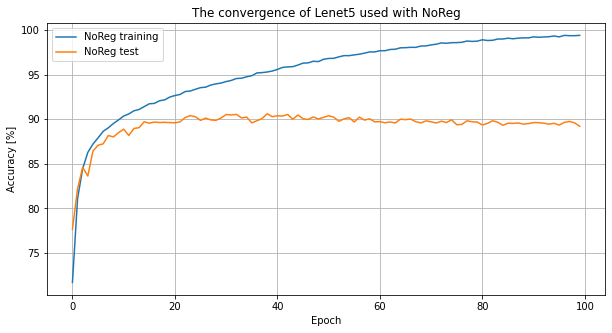

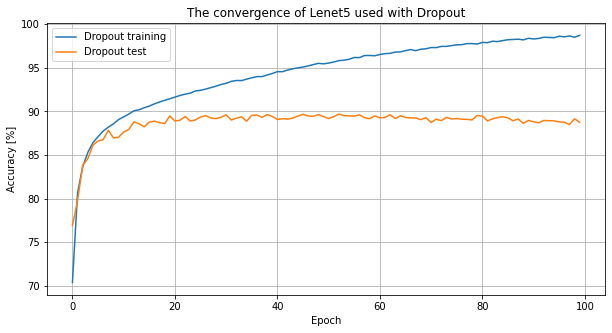

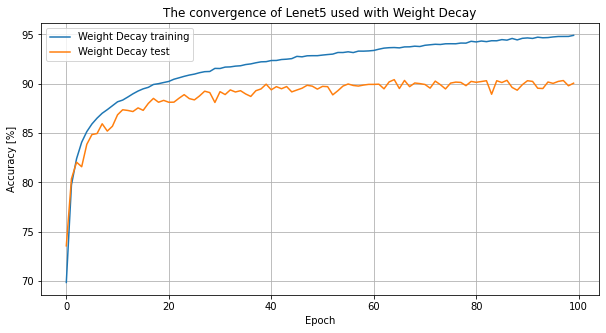

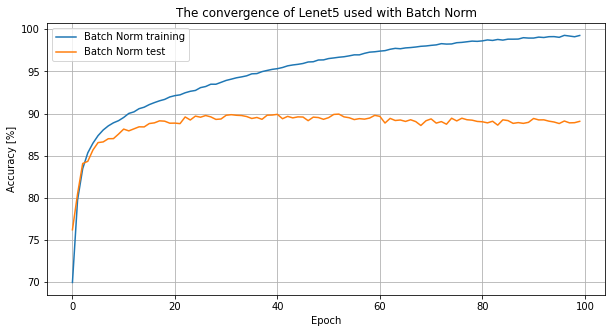

In [ ]:
for name in ['NoReg','Dropout','Weight Decay','Batch Norm']:
  data = [name+' training', name+' test']
  title = 'The convergence of Lenet5 used with '+ name
  plt_df[data].plot(xlabel="Epoch", ylabel="Accuracy [%]", grid=True, figsize=(10, 5), title= title)

**6. Plot 8 accuracy graphs.** *One graph for the accuracy of the trained data and one for the test*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbea4e8fa90>,
      dtype=object)

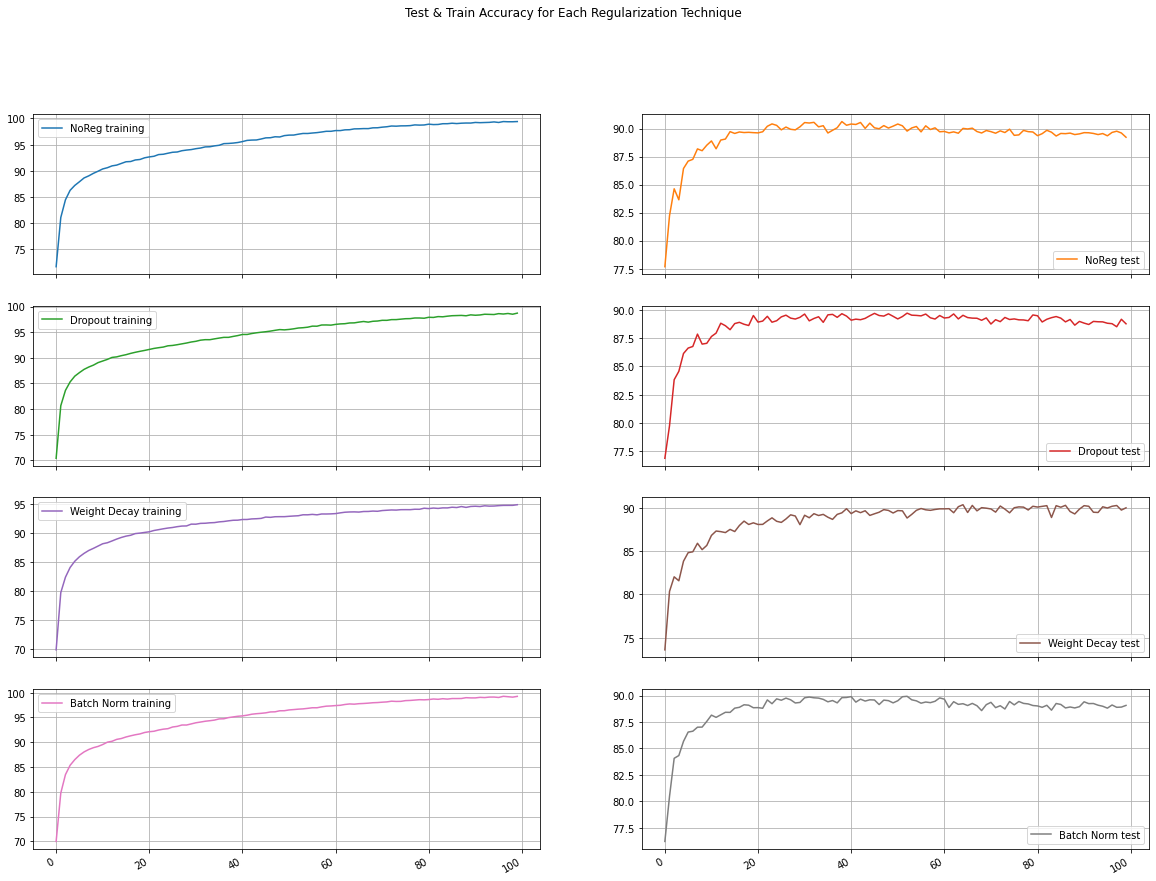

In [ ]:
plt_df.plot(subplots=True, layout=(4, 2), figsize=(20, 15),
            grid=True, title="Test & Train Accuracy for Each Regularization Technique")

# **Testing Trained Nets**
*Loads a trained model and add it's testing accuracy to a comperative table.*

***An action is requireed in cell 2*** *to be able to load the models from the correct path*

**1. Create a dict** *to store accuracy results of the tests of trained net*

In [ ]:
trained_score_dict = {'Technique':['NoReg','Dropout','Weight Decay','Batch Normalization'], 
                'Accuracy':["Didn't update properly!"]*4}   #error messege that should be replaced by a number


**2. Load and test the trained nets.** *Show results in a table*

In [ ]:
# loop over trained nets and update 'Accuracy' column
for i,trained_net in enumerate(['NoReg.pt','Dropout.pt','WeightDecay.pt','BatchNormalization.pt']):
    ##########################################
    # ACTION NEEDED! Change to a relevant path
    ##########################################
    print('Loading '+trained_net)
    path = f'/content/gdrive/MyDrive/Deep Learning/EX1_302338470/Trained Models/{trained_net}'
    net = LeNet5()
    net.to('cuda')
    net.load_state_dict(torch.load(path))
    print('Updating accuracy...')
    # define booleans for Dropout and BatchNormalization and test acuraccy: 
    if i==1: score = TestAccuracy(net,True,False)
    elif i==3: score = TestAccuracy(net,False,True)
    else: score =TestAccuracy(net,False,False)
    trained_score_dict['Accuracy'][i] = score


# print this new table of testings scores
print('Results of testing the trained models:')
trained_score_df = pd.DataFrame(data=trained_score_dict)
trained_score_df


Loading NoReg.pt
Updating accuracy...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


              Test Accuracy: 89.76
Loading Dropout.pt
Updating accuracy...
              Test Accuracy: 89.15
Loading WeightDecay.pt
Updating accuracy...
              Test Accuracy: 90.05
Loading BatchNormalization.pt
Updating accuracy...
              Test Accuracy: 89.07
Results of testing the trained models:


,Technique,Accuracy
0,NoReg,89.76
1,Dropout,89.15
2,Weight Decay,90.05
3,Batch Normalization,89.07
